# Connect to drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Install necessary packages

In [ ]:
!pip install tensorflow scikit-learn matplotlib

# Importing Libraries

In [ ]:
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_dir = '/content/gdrive/MyDrive/ISIC_Labelled -4GB'

# Load Images For Training & Testing

In [ ]:
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1 / 255,
                                validation_split=0.2,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory= data_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.2,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                    ),
}

# Initialize MobileNet-v2 Pretrained Model

In [ ]:
# Initializing MobileNetv2 (pretrained) model with input image shape as (300, 300, 3)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3), classes=8)

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

# Add Custom Layer

In [ ]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(8, activation='softmax') # 8 Output Neurons for 8 Classes
])

In [ ]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# View Model Summary & Plot

In [ ]:
# Viewing the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_3 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 3577928 (13.65 MB)
Trainable params: 131

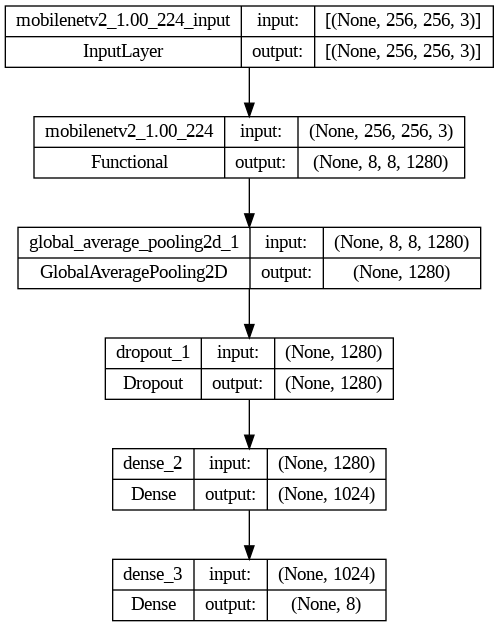

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

# Model Building

In [ ]:
# Setting variables for the model
batch_size = 16
epochs = 30

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [ ]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 427
validation_steps : 106


# Model Training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    verbose=1
)

Epoch 1/30
213/213 [==============================] - 2509s 12s/step - loss: 1.4975 - accuracy: 0.4558 - val_loss: 1.4333 - val_accuracy: 0.4906
Epoch 2/30
213/213 [==============================] - 750s 4s/step - loss: 1.3361 - accuracy: 0.5095 - val_loss: 1.3431 - val_accuracy: 0.5065
Epoch 3/30
213/213 [==============================] - 737s 3s/step - loss: 1.2789 - accuracy: 0.5267 - val_loss: 1.3021 - val_accuracy: 0.5065
Epoch 4/30
213/213 [==============================] - 740s 3s/step - loss: 1.2331 - accuracy: 0.5475 - val_loss: 1.2957 - val_accuracy: 0.5307
Epoch 5/30
213/213 [==============================] - 742s 3s/step - loss: 1.2097 - accuracy: 0.5505 - val_loss: 1.2534 - val_accuracy: 0.5430
Epoch 6/30
213/213 [==============================] - 743s 3s/step - loss: 1.1824 - accuracy: 0.5616 - val_loss: 1.3021 - val_accuracy: 0.5242
Epoch 7/30
213/213 [==============================] - 744s 3s/step - loss: 1.1670 - accuracy: 0.5677 - val_loss: 1.2625 - val_accuracy: 0.53

# Model Evaluation

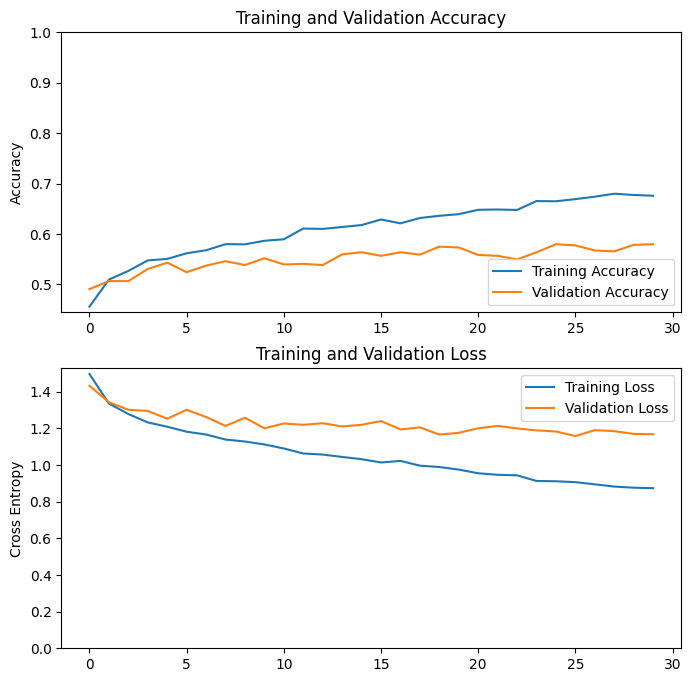

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

54/54 [==============================] - 126s 2s/step - loss: 1.1723 - accuracy: 0.5798
test accuracy :  0.579812228679657
